In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sc
from astropy.visualization.hist import hist as fancyhist
from sklearn.neighbors import KernelDensity

### Generating $\chi$ and $M$ samples
$\chi$ is the spin and is distributed uniformly, betweeen 0 and 1. The mass $M$ is distributed Gaussianly with given $\mu$ and $\sigma$.
Let's create some samples.

[Text(0.5, 0, '$M$'), Text(0, 0.5, 'p($M$)'), Text(0.5, 1.0, '$M$ histogram')]

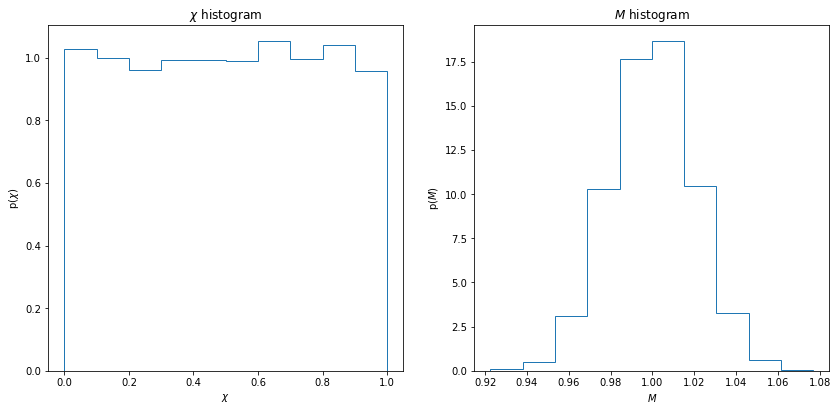

In [3]:
Nsamples = 10000

chi = np.random.uniform(0, 1, Nsamples)

mean = 1
sigma = 0.02
mass = np.random.normal (mean, sigma, Nsamples)

fig = plt.figure(figsize=(14, 14))

ax = fig.add_subplot(221)
ax.hist (chi, histtype='step', density = True)
ax.set(xlabel = '$\chi$', ylabel = 'p($\chi$)', title = '$\chi$ histogram')

ax = fig.add_subplot(222)
ax.hist(mass, histtype='step', density = True)
ax.set(xlabel = '$M$', ylabel = 'p($M$)', title = '$M$ histogram')

### Irreducible mass samples + KDE
Obtained by using the samples of chi and the mass, then using sklearn to plot a KDE with Gaussian kernels.

In [4]:
def get_M_irr (chi, mass): #if mass = 1 corresponds to f
    m_irr = mass * np.sqrt(0.5 * (1 + np.sqrt(1 - np.power(chi, 2))))
    return m_irr

def kde_sklearn(data, bandwidth = 1.0, kernel="linear"):
    kde_skl = KernelDensity(bandwidth = bandwidth, kernel=kernel)
    kde_skl.fit(data[:, np.newaxis])
    log_pdf = kde_skl.score_samples(m_irr[:, np.newaxis]) # sklearn returns log(density)
    return np.exp(log_pdf) 

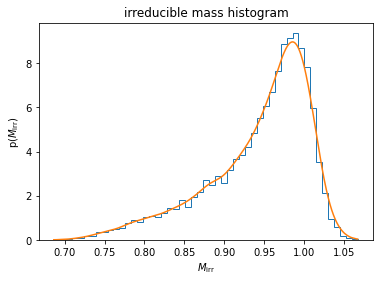

In [5]:
m_irr = get_M_irr(chi, mass)

_ = fancyhist(m_irr, bins="freedman", histtype="step",density=True)
plt.title('irreducible mass histogram')
plt.xlabel('$M_\mathrm{irr}$')
plt.ylabel('p($M_\mathrm{irr}$)')

m_irr.sort()
gauss_pdf = kde_sklearn(m_irr,bandwidth=0.01,kernel="gaussian")
plt.plot(m_irr, gauss_pdf)

We can also plot the distribution of $f$, which we will need later.

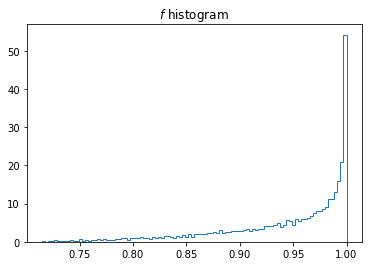

In [9]:
f = get_M_irr(chi, 1)

plt.hist(f, int(np.sqrt(Nsamples)), histtype = 'step', density = True)
plt.title('$f$ histogram')
plt.show()

### KS distance
We compute the KS distance between both $M_\mathrm{irr}$ and $f$ and $M_\mathrm{irr}$ and $M$ as a function of $\sigma$. We use the function **scipy.stats.ks_2samp(data1, data2, alternative='two-sided', method='auto', *, axis=0, nan_policy='propagate', keepdims=False)** which does the following:

    Performs the two-sample Kolmogorov-Smirnov test for goodness of fit.
    This test compares the underlying continuous distributions F(x) and G(x) of two independent samples. 
    
If we change $\sigma$, the distribution of $\chi$ (as well as $f$) remains the same, whereas $M$ will change, and so will $M_\mathrm{irr}$.

In [10]:
sigmas_n = 20 #number of sigma values
sigmas = np.logspace(-5, 5, sigmas_n) #logarithmically distributed between 1e-5 1e+5
N = 10000 #number of samples

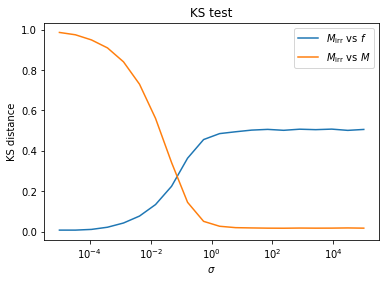

In [11]:
chi_samples = np.random.uniform(0, 1, N)
f_samples = get_M_irr(chi_samples, 1)

mass_samples = [np.random.normal(mean, s, N) for s in sigmas]
irr_mass_samples = [get_M_irr(chi, m) for m in mass_samples]

KS_mf = [sc.ks_2samp(ims, f_samples) for ims in irr_mass_samples]
KS_mm = [sc.ks_2samp(ims, ms) for ims, ms in zip(irr_mass_samples, mass_samples)]

ksf = []
ksm = []
for i in range(sigmas_n): 
    ksf.append(KS_mf[i][0])
    ksm.append(KS_mm[i][0])

plt.plot(sigmas, ksf, label='$M_\mathrm{irr}$ vs $f$')
plt.plot(sigmas, ksm, label='$M_\mathrm{irr}$ vs $M$')
plt.xlabel('$\sigma$')
plt.ylabel('KS distance')
plt.title('KS test')
plt.semilogx()
plt.legend()
plt.show()

For small sigmas, the distribution of $M_\mathrm{irr}$ should converge to the one of $f$, while for large sigmas it should converge to $M$! This is because in the respective limits, the KS distance goes to zero.

### $M_\mathrm{irr}$ distribution as a function of $\sigma$
To confirm the KS test, we create new samples with a small and large limit of $\sigma$ to visualise the trend of the irreducible mass.

In [12]:
def chi_mass_samples (N, mean, sigma):
    chi = np.random.uniform(0, 1, N)
    mass = np.random.normal(mean, sigma, N)
    return chi, mass

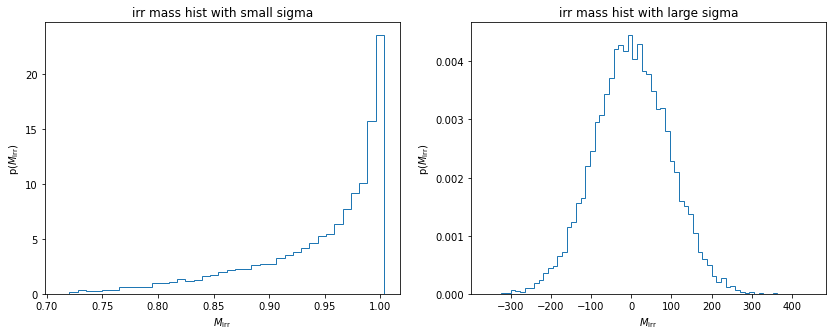

In [14]:
small_sigma = 0.0001
large_sigma = 100

fig = plt.figure(figsize=(14, 5))

#-- small sigma
schi, smass = chi_mass_samples(Nsamples, mean, small_sigma)
s_m_irr = get_M_irr(schi, smass)

ax = fig.add_subplot(121)
_ = fancyhist(s_m_irr, bins="freedman", histtype="step",density=True)
ax.set(xlabel='$M_\mathrm{irr}$', ylabel = 'p($M_\mathrm{irr}$)', title = 'irr mass hist with small sigma')


#-- large sigma
lchi, lmass = chi_mass_samples(Nsamples, mean, large_sigma)
l_m_irr = get_M_irr(lchi, lmass)

ax = fig.add_subplot(122)
_ = fancyhist(l_m_irr, bins="freedman", histtype="step",density=True)
ax.set(xlabel='$M_\mathrm{irr}$', ylabel = 'p($M_\mathrm{irr}$)', title = 'irr mass hist with large sigma')


plt.show()

They do in fact look like $f$ and $M$!

### Computation and comparison of the pdf of $M_\mathrm{irr}$

We finally need to compute explicitly the pdf of $M_\mathrm{irr}$ and compare it with our KDE. We do it by starting from:
$$p(f) = \left| \frac{d\chi}{df} \right| p(\chi)$$

and finding that
$$\chi(f) = 2f \sqrt{1 - f^2} \, ,$$


$$\frac{d\chi}{df} = 2\frac{1 - 2f^2}{\sqrt{1-f^2}} \, .$$

Since $\chi$ is distributed uniformly and f is in the range [$\frac{1}{\sqrt{2}}$ - 1], we obtain:
$$p(f) = 2\frac{2f^2 - 1}{\sqrt{1-f^2}} \, .$$

We can now find the distribution of $M_\mathrm{irr}$ which corresponds to:
$$p(M_\mathrm{irr}) = \int_{-\infty}^{+\infty} p_M(\frac{M_\mathrm{irr}}{f}) \, p_f(f)\,  \frac{1}{|f|} \,df = \sqrt{\frac{2}{\pi \,\sigma^2}} \, \int_{1/\sqrt2}^{1} df \frac{2}{f}\frac{2f^2 - 1}{\sqrt{1-f^2}} \, e^{-\frac{(M_\mathrm{irr}/f - \mu)^2}{2\sigma^2}} $$

which is the pdf of the product of 2 independent random variables.

In [39]:
import scipy

def f_pdf(f):
    return (2/f) * (2 * f**2 - 1)/(np.sqrt(1 - f**2))

def m_pdf(x, mean, sigma):
    return np.exp(-np.power(x - mean, 2)/(2 * (sigma**2)))

def mirr_pdf(mirr, mean, sigma):
    const = 1/sigma * np.sqrt(2/np.pi)
    integral = lambda x: const * f_pdf(x) * m_pdf(mirr/x, mean, sigma)
    
    mirr_pdf = scipy.integrate.quad(integral, 1/np.sqrt(2), 1)
    return mirr_pdf

mean = 1
sigma = 0.02

<ipython-input-39-c6524a832709>:13: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  mirr_pdf = scipy.integrate.quad(integral, 1/np.sqrt(2), 1)


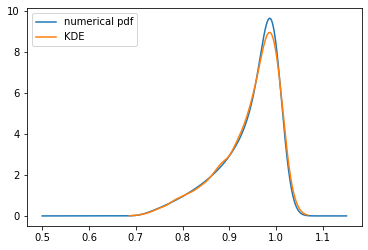

In [64]:
mirr_samples = np.linspace(0.5, 1.15, 1000)

y = []
for i in range(1000):
    mirrpdf = mirr_pdf(mirr_samples[i], mean, sigma)
    y.append(mirrpdf[0]/2)
    
plt.plot(mirr_samples, y, label = 'numerical pdf')
plt.plot(m_irr, gauss_pdf, label = 'KDE')
plt.legend()
plt.show()

They do! Probably have to check some normalisations though.